# Prepare dataset

In [1]:
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn

# local path
# FAULT_DATA_DIR = "D:\\Windows_Storage\\Storage\\Github\\phm_etching_01M01-02\\M02_Groups_same_length\\fault"
# HEALTHY_DATA_DIR = "D:\\Windows_Storage\\Storage\\Github\\phm_etching_01M01-02\\M02_Groups_same_length\\healthy"

# server path
FAULT_DATA_DIR = "C:\\Users\\User\\Desktop\\Ricardo\\phm_etching_01M01-02\\M02_Groups_recipe_67_same_length\\fault\\"
HEALTHY_DATA_DIR = "C:\\Users\\User\Desktop\\Ricardo\\phm_etching_01M01-02\\M02_Groups_recipe_67_same_length\\healthy\\"
HEALTHY_DATA_NUM = 19
RANDOM_SEED = 100

In [2]:
np.random.seed(RANDOM_SEED)

os.chdir(FAULT_DATA_DIR)

# read in fault data
fault_file_list = os.listdir()
np.random.shuffle(fault_file_list)

for fileIndex, file in enumerate(tqdm(fault_file_list)):
    if fileIndex == 0:
        data_all = pd.read_csv(file, encoding="utf8")
    else:
        data_import = pd.read_csv(file, encoding="utf8")
        data_all = data_all.append(data_import, ignore_index = True)
        
os.chdir(HEALTHY_DATA_DIR)

healthy_file_list = os.listdir()
np.random.shuffle(healthy_file_list)

print(healthy_file_list[:HEALTHY_DATA_NUM])

for fileIndex, file in enumerate(tqdm(healthy_file_list[:HEALTHY_DATA_NUM])):
    data_import = pd.read_csv(file, encoding="utf8")
    data_all = data_all.append(data_import, ignore_index = True)

# shuffle dataframe
# data_all = data_all.sample(frac=1).reset_index(drop=True)

 37%|███▋      | 7/19 [00:00<00:00, 61.09it/s]

['TotalFault_0_Healthy_Lot_runnum_9247-12187167.csv', 'TotalFault_0_Healthy_Lot_runnum_9207-10619065.csv', 'TotalFault_0_Healthy_Lot_runnum_9161-11143064.csv', 'TotalFault_0_Healthy_Lot_runnum_9682-12271399.csv', 'TotalFault_0_Healthy_Lot_runnum_9621-12261764.csv', 'TotalFault_0_Healthy_Lot_runnum_9177-11534406.csv', 'TotalFault_0_Healthy_Lot_runnum_9653-12725979.csv', 'TotalFault_0_Healthy_Lot_runnum_9612-12526543.csv', 'TotalFault_0_Healthy_Lot_runnum_9400-11272860.csv', 'TotalFault_0_Healthy_Lot_runnum_9694-12506689.csv', 'TotalFault_0_Healthy_Lot_runnum_9209-10783497.csv', 'TotalFault_0_Healthy_Lot_runnum_9435-11046645.csv', 'TotalFault_0_Healthy_Lot_runnum_9612-12481868.csv', 'TotalFault_0_Healthy_Lot_runnum_9353-12016699.csv', 'TotalFault_0_Healthy_Lot_runnum_9180-11590298.csv', 'TotalFault_0_Healthy_Lot_runnum_9613-12396135.csv', 'TotalFault_0_Healthy_Lot_runnum_9186-10530457.csv', 'TotalFault_0_Healthy_Lot_runnum_9637-12501093.csv', 'TotalFault_0_Healthy_Lot_runnum_9238-1182377

100%|██████████| 19/19 [00:00<00:00, 55.59it/s]


# Data Loaded

In [3]:
MODEL_SAVE_PATH = "C:\\Users\\User\Desktop\\Ricardo\\PHM_ion-mill-etch-tool\\Models\\210619_5_LSTM.pt"
LOSS_GRAPH_PATH = "./210619_5_LSTM.svg"

MODEL_LOAD_PATH = "C:\\Users\\User\Desktop\\Ricardo\\PHM_ion-mill-etch-tool\\Models\\210619_5_LSTM.pt"

SEQ_LENGTH = 50

batch_size = 5000
learning_rate = 0.01
num_epochs = 2000

input_size = 13
hidden_size = 10
num_layers = 1

num_classes = 1

In [4]:
# create datasets with given sequence length
def sliding_windows(data, seq_length, selected_column):
    x = []
    y = []
    
    # calculate max min for each column
    data_temp = data.drop(columns=['time', 'Tool', 'Lot', 'Lot-runnum'])
    
    column_list = data_temp.columns.tolist()
    max_value_list = data_temp.max().tolist()
    min_value_list = data_temp.min().tolist()
    
    # normalize the data
    for column in data.columns:
        if column in ['time', 'Tool', 'Lot', 'Lot-runnum']:
            continue
            
        # x ′ = ( x − x m i n ) / ( x m a x − x m i n )
        column_index = column_list.index(column)
        data[column] = data[column].apply(lambda x: \
                                          (x - min_value_list[column_index]) / (max_value_list[column_index] - \
                                                                   min_value_list[column_index]))
        
#     print(data.head(5))

    for i in tqdm(range(len(data)-seq_length-1)):
        # create x and y 
        data_x = data.iloc[i:(i+seq_length), :]
        data_y = data.loc[[(i+seq_length)], [selected_column]]
        
        # skip if contains for than two Lot-runnum and np.nan appears in y
        if data_x["Lot-runnum"].nunique() > 1:
            continue
            
        # drop nan value
        if data_y[selected_column].isnull().values.any() or\
        data_x.isnull().values.any() :
            continue
        
        # drop unneccessary columns
        data_x.drop(columns=['time', 'Tool', 'Lot', 'TTF_FlowCool Pressure Dropped Below Limit',
       'TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', 'Lot-runnum',
                             'recipe_step', 'recipe', 'stage', 'runnum', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER',
       'ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION'],
                     inplace=True)
        
        x.append(data_x)
        y.append(data_y)
        
    np.random.seed(RANDOM_SEED)   
    np.random.shuffle(x)
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(y)

    return np.array(x), np.array(y)

# Pytorch Reference
#### CUDA Implementation Reference
* https://pytorch.org/docs/stable/generated/torch.Tensor.to.html
* https://pytorch.org/docs/stable/tensors.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html

#### Saving & Load Model Reference:
* https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
* https://pytorch.org/tutorials/beginner/saving_loading_models.html

#### Batch Training Reference:
* https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way

In [5]:
# activate cuda

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
print(is_cuda)

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


In [6]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = SEQ_LENGTH
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# TTF_FlowCool Pressure Dropped Below Limit

In [7]:
SELECTED_COLUMN = 'TTF_FlowCool Pressure Dropped Below Limit'

x, y = sliding_windows(data_all, SEQ_LENGTH, SELECTED_COLUMN)
y = np.squeeze(y, axis=2)

# print(x.shape, y.shape)

  2%|▏         | 1379/55885 [00:01<01:02, 871.31it/s]c:\users\user\anaconda3\envs\nlp\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
100%|██████████| 55885/55885 [01:15<00:00, 737.30it/s] 


In [131]:
train_size = int(len(y) * 0.7)
validation_size =  int(len(y) * 0.95)
test_size = len(y) - validation_size


if is_cuda:
    dataX = Variable(torch.Tensor(np.array(x)).cuda(device=0))
    dataY = Variable(torch.Tensor(np.array(y)).cuda(device=0))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])).cuda(device=0))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])).cuda(device=0))
    
    validX = Variable(torch.Tensor(np.array(x[train_size:validation_size])).cuda(device=0))
    validY = Variable(torch.Tensor(np.array(y[train_size:validation_size])).cuda(device=0)) 

    testX = Variable(torch.Tensor(np.array(x[validation_size:len(x)])).cuda(device=0))
    testY = Variable(torch.Tensor(np.array(y[validation_size:len(y)])).cuda(device=0))
else:
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
    
    validX = Variable(torch.Tensor(np.array(x[train_size:validation_size])))
    validY = Variable(torch.Tensor(np.array(y[train_size:validation_size]))) 

    testX = Variable(torch.Tensor(np.array(x[validation_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[validation_size:len(y)])))

print(trainX.shape, trainY.shape, "\n", testX.shape, testY.shape)
print(dataX.shape, dataY.shape)

torch.Size([23904, 50, 13]) torch.Size([23904, 1]) 
 torch.Size([1708, 50, 13]) torch.Size([1708, 1])
torch.Size([34149, 50, 13]) torch.Size([34149, 1])


In [9]:
epoch_list = []
train_loss_list = []
valid_loss_list = []

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

if is_cuda:
    lstm = lstm.cuda()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    
    # X is a torch Variable
    permutation = torch.randperm(trainX.size()[0])
    lstm.train()
    
    for i in range(0,trainX.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = trainX[indices], trainY[indices]

        # in case you wanted a semi-full example
        outputs = lstm.forward(batch_x)
        loss = criterion(outputs,batch_y)

        loss.backward()
        optimizer.step()
    
    optimizer.step()
    
    # validation part
    lstm.eval()
    valid_outputs = lstm.forward(validX)
    valid_loss = criterion(valid_outputs, validY)
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item() * (dataX.size(0) / trainX.size(0))))
        print("Epoch: %d, validation loss: %1.5f" % (epoch, valid_loss.item() * (dataX.size(0) / validX.size(0))))
        epoch_list.append(epoch)
        train_loss_list.append((epoch, loss.item() * (dataX.size(0) / trainX.size(0)))[1])
        valid_loss_list.append((epoch, valid_loss.item() * (dataX.size(0) / validX.size(0)))[1])
        
# save model
torch.save(lstm.state_dict(), MODEL_SAVE_PATH)

Epoch: 0, loss: 0.09438
Epoch: 0, validation loss: 0.24957
Epoch: 100, loss: 0.07307
Epoch: 100, validation loss: 0.18068
Epoch: 200, loss: 0.07135
Epoch: 200, validation loss: 0.18754
Epoch: 300, loss: 0.05588
Epoch: 300, validation loss: 0.15366
Epoch: 400, loss: 0.04746
Epoch: 400, validation loss: 0.14289
Epoch: 500, loss: 0.05784
Epoch: 500, validation loss: 0.14177
Epoch: 600, loss: 0.04547
Epoch: 600, validation loss: 0.16996
Epoch: 700, loss: 0.04188
Epoch: 700, validation loss: 0.11558
Epoch: 800, loss: 0.05725
Epoch: 800, validation loss: 0.15085
Epoch: 900, loss: 0.03615
Epoch: 900, validation loss: 0.10482
Epoch: 1000, loss: 0.03807
Epoch: 1000, validation loss: 0.10350
Epoch: 1100, loss: 0.04121
Epoch: 1100, validation loss: 0.10278
Epoch: 1200, loss: 0.03056
Epoch: 1200, validation loss: 0.09045
Epoch: 1300, loss: 0.03538
Epoch: 1300, validation loss: 0.10719
Epoch: 1400, loss: 0.03183
Epoch: 1400, validation loss: 0.08880
Epoch: 1500, loss: 0.03922
Epoch: 1500, validatio

# Plot Loss Curve

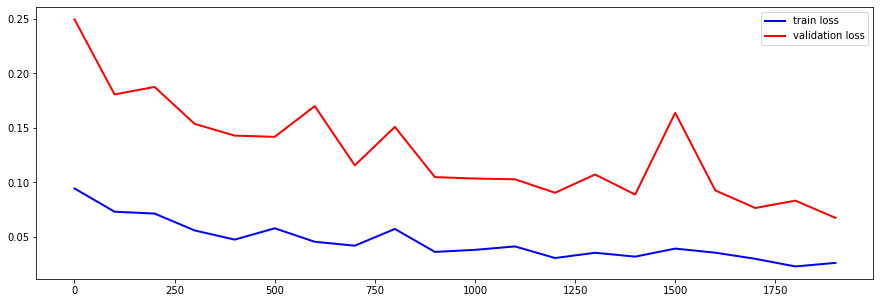

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(epoch_list, train_loss_list, color="blue", linewidth=2, label="train loss")
plt.plot(epoch_list, valid_loss_list, color="red", linewidth=2, label="validation loss")
plt.legend(loc="upper right")
os.chdir("C:\\Users\\User\Desktop\\Ricardo\\PHM_ion-mill-etch-tool\\Graphs\\")
plt.savefig(LOSS_GRAPH_PATH, format='svg', bbox_inches="tight")
plt.show()

# Prediction with Model

In [124]:
# load model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.load_state_dict(torch.load(MODEL_LOAD_PATH))
lstm.cuda()
lstm.eval()

LSTM(
  (lstm): LSTM(13, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

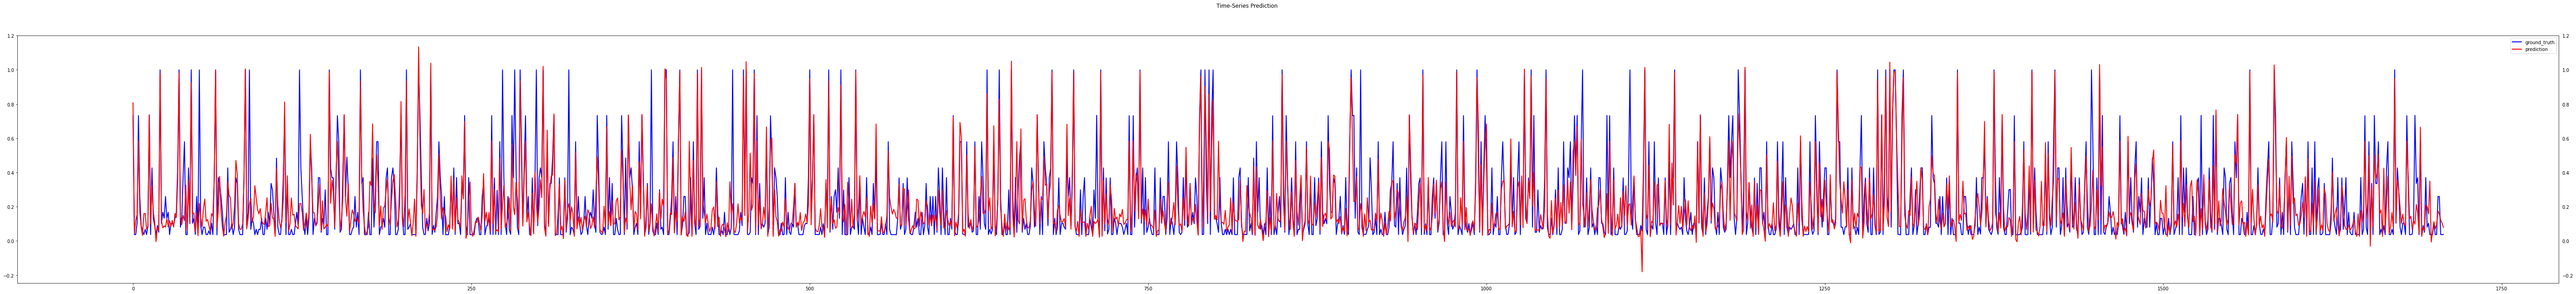

In [125]:
# prediction
lstm.eval()
train_predict = lstm(testX)

train_predict = train_predict.cpu()
data_predict = train_predict.data.numpy()
testY = testY.cpu()
dataY_plot = testY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(100,10))

# plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color="blue", linewidth=2, label="ground_truth")
plt.plot(data_predict, color="red", linewidth=2, label="prediction")
plt.legend(loc="upper right")
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.suptitle('Time-Series Prediction')
plt.savefig("C:/Users/User/Desktop/Ricardo/PHM_ion-mill-etch-tool/Graphs/TTF_FlowCoolPressureDroppedBelowLimit.svg", format='svg', bbox_inches="tight")
plt.show()

# Variable Importance Check

## By Captum
* https://captum.ai/tutorials/
* https://captum.ai/tutorials/Titanic_Basic_Interpret
* https://captum.ai/api/deep_lift.html

In [126]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from captum.attr import DeepLift
import matplotlib.pyplot as plt

FEATURE_NUM = 13

In [127]:
lstm.train()
dl = DeepLift(lstm)

print(trainX.shape, trainY.shape)
attribution = dl.attribute(trainX, target=0)

# deal with attribution
attribution = attribution.detach().cpu().numpy()
attribution = np.squeeze(attribution)
print(attribution.shape)

torch.Size([23904, 50, 13]) torch.Size([23904, 1])


c:\users\user\anaconda3\envs\nlp\lib\site-packages\captum\attr\_core\deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


(23904, 50, 13)


In [128]:
feature_importance = np.zeros((50, FEATURE_NUM))

for tensorIndex, tensor in enumerate(attribution):
    feature_importance +=  tensor
    
feature_importance = feature_importance / attribution.shape[0]
print(feature_importance.shape)

(50, 13)


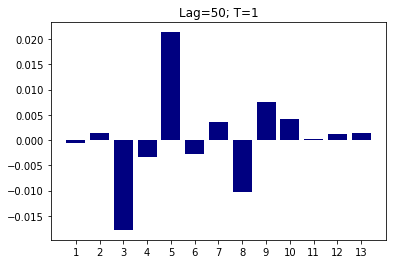

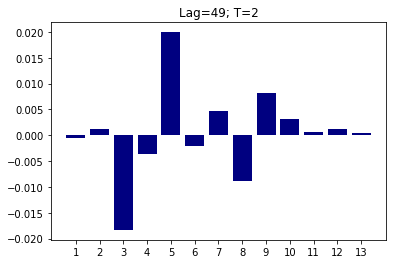

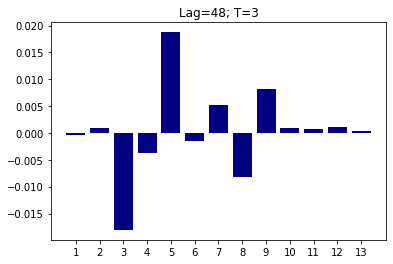

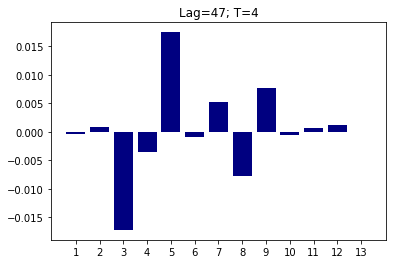

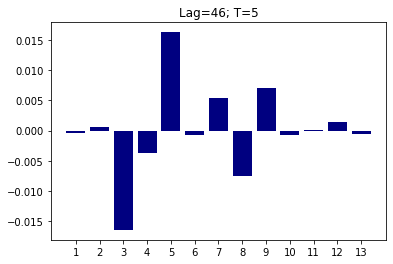

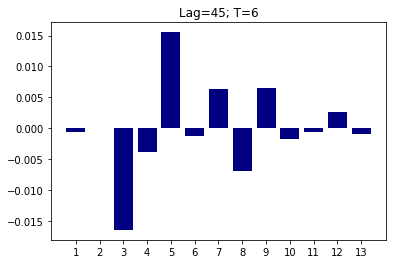

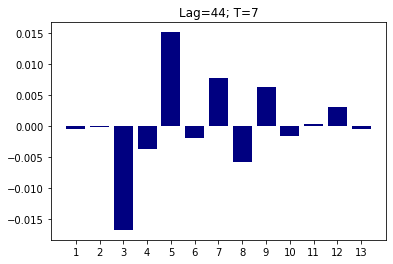

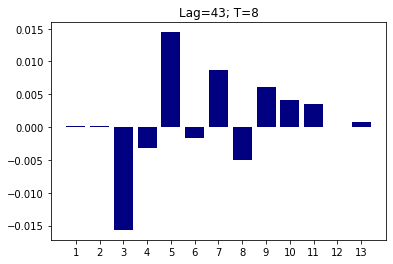

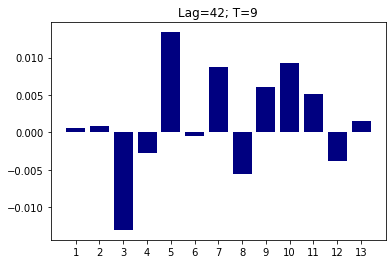

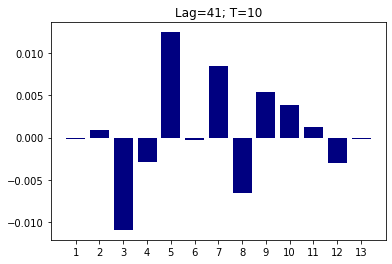

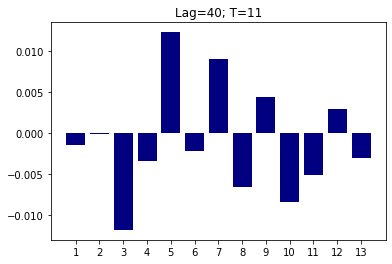

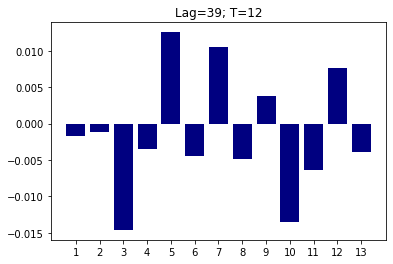

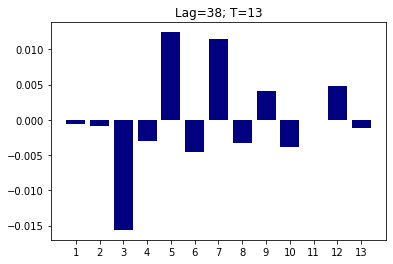

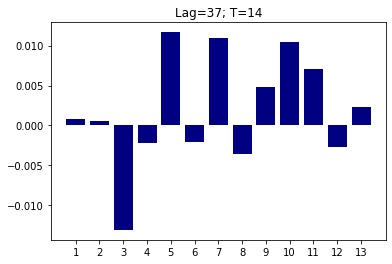

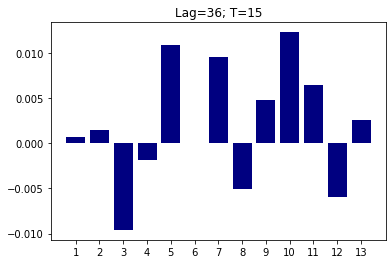

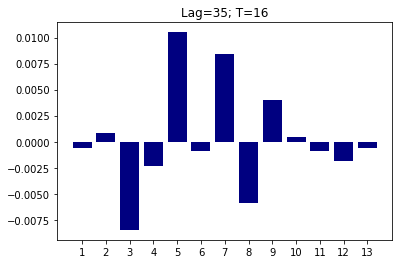

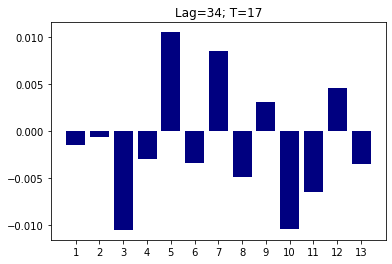

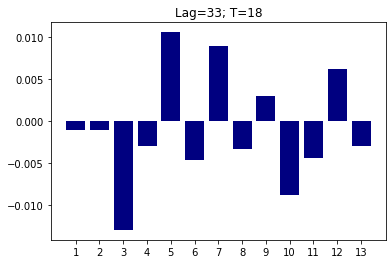

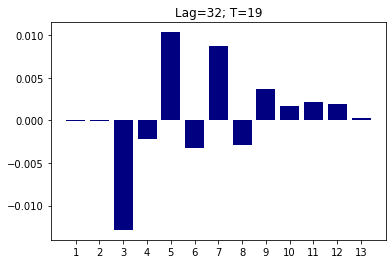

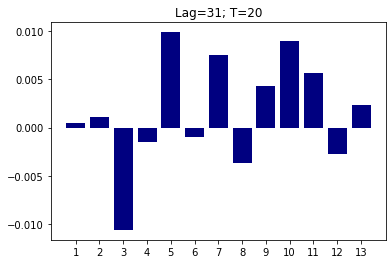

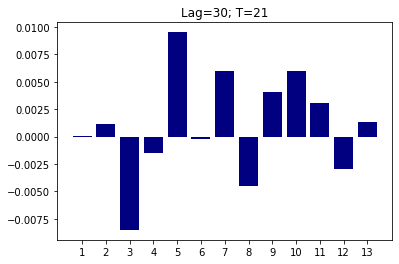

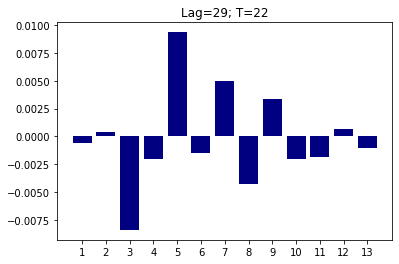

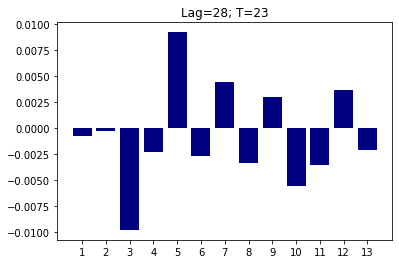

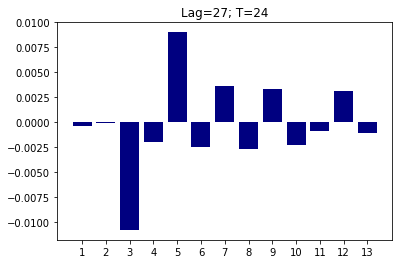

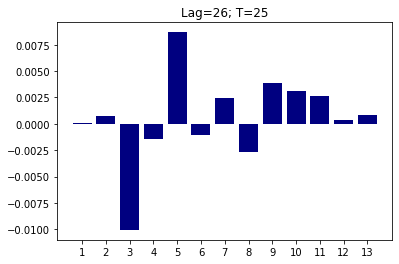

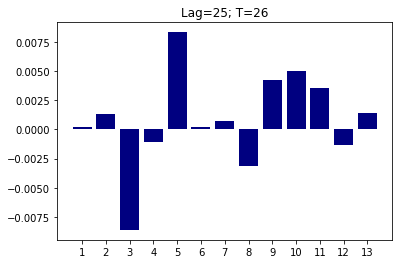

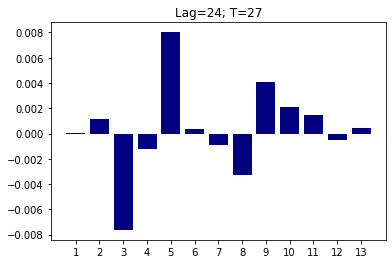

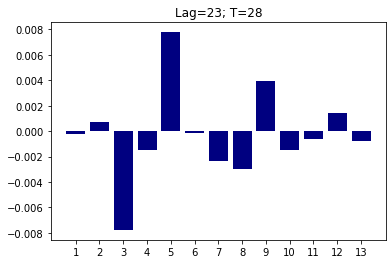

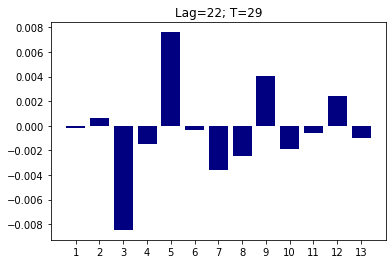

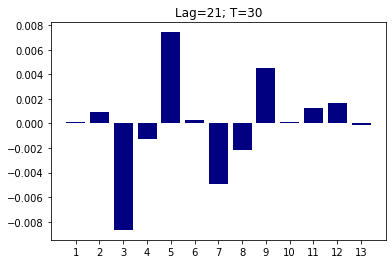

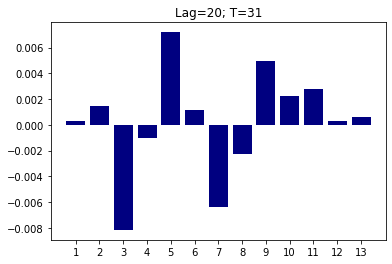

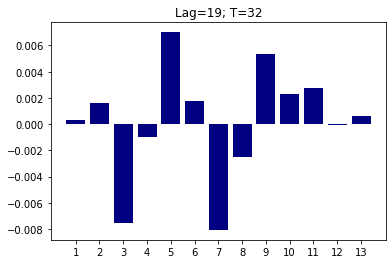

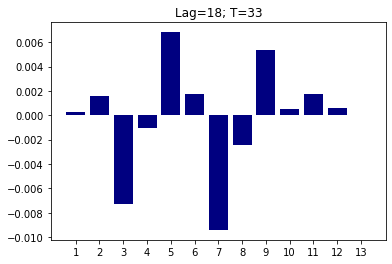

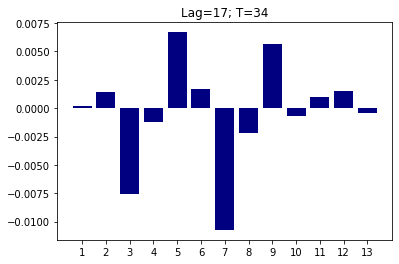

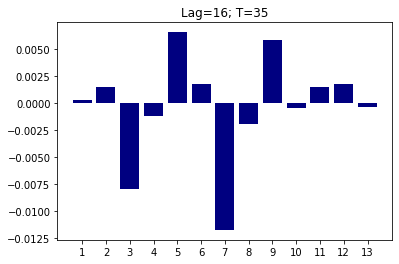

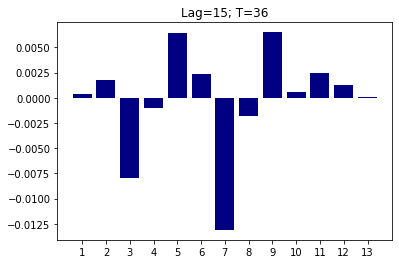

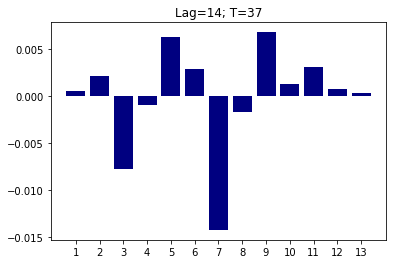

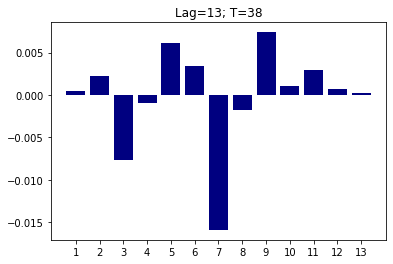

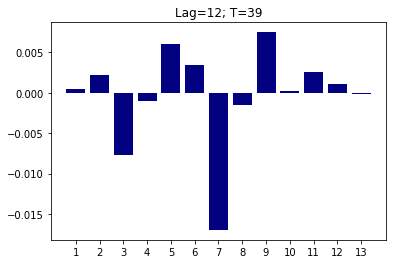

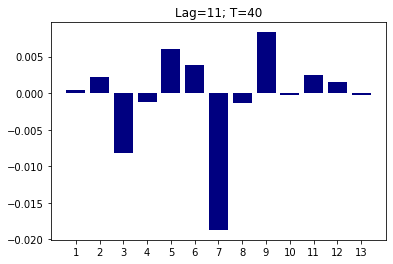

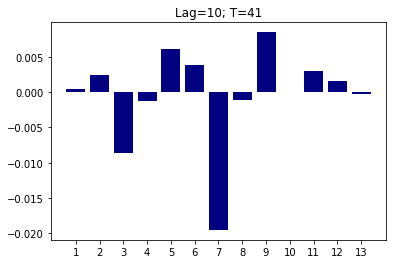

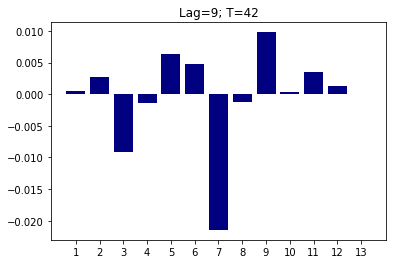

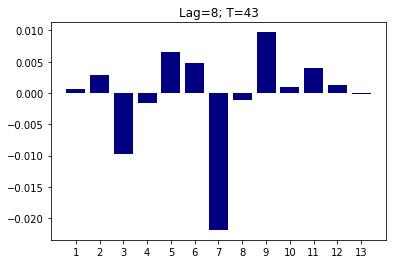

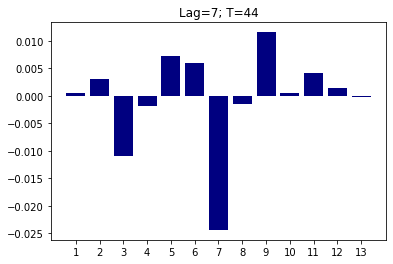

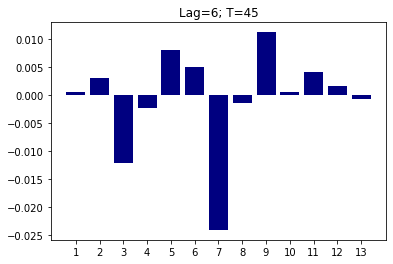

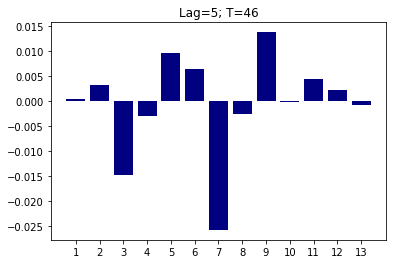

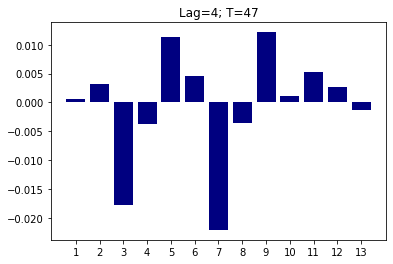

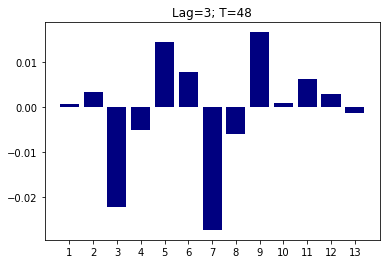

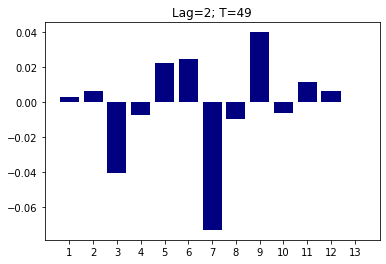

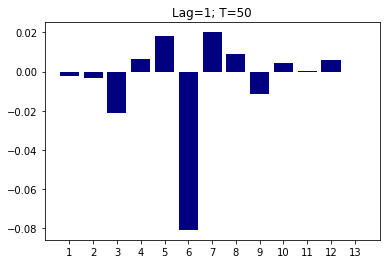

In [130]:
for tensorIndex, tensor in enumerate(feature_importance):
    
    for itemIndex, item in enumerate(tensor.tolist()):
        plt.bar(itemIndex+1, item, align='center', color="navy") 
        
    plt.title("Lag=" + str(50 - tensorIndex) + "; T=" + str(tensorIndex + 1))
    plt.xticks([(i+1) for i in range(FEATURE_NUM)])
    plt.savefig("C:/Users/User/Desktop/Ricardo/PHM_ion-mill-etch-tool/Graphs/" + str(tensorIndex+1) +".svg",
           format="svg",
           bbox_inches="tight")
    plt.show()

In [ ]:


tensor_sum_list = [0 for i in range(FEATURE_NUM)]


for tensor in attribution:
    for itemIndex, item in enumerate(tensor.tolist()):
        tensor_sum_list[itemIndex] += np.abs(item)

plt.figure(figsize=(15,5))
for i in range(17):
    plt.bar(i+1,tensor_sum_list[i], align='center', color="navy") 
    
plt.xticks([(i+1) for i in range(17)])
plt.savefig("C:/Users/User/Desktop/Ricardo/PHM_ion-mill-etch-tool/Graphs/attribution.svg",
           format="svg",
           bbox_inches="tight")

In [ ]:
'''
An important thing to note is that the average attributions over the test set 
don't necessarilly capture all the information regarding feature importances. 
We should also look at the distribution of attributions for each feature. 
It is possible that features have very different attributions for different examples in the dataset.
'''
plt.hist(attribution[:,13], 30);
plt.title("Distribution of Sibsp Attribution Values");

In [ ]:
# print('IG Attributions:', attribution)
# print('Convergence Delta:', delta)

tensor_sum_list = [0 for i in range(17)]

for tensor in delta:
    for itemIndex, item in enumerate(tensor.tolist()):
        tensor_sum_list[itemIndex] += item
        
plt.figure(figsize=(15,5))
for i in range(17):
    plt.bar(i+1,tensor_sum_list[i], align='center', color="navy") 
    
plt.xticks([(i+1) for i in range(17)])
plt.savefig("C:/Users/User/Desktop/Ricardo/PHM_ion-mill-etch-tool/Graphs/delta.svg",
           format="svg",
           bbox_inches="tight")